In [34]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Callable, Literal

In [35]:
def generate_nodes(func: Callable[[float], float], a: float, b: float, n: int) -> Tuple[np.ndarray, np.ndarray]:
  x = np.linspace(a, b, n)
  nodes = np.array([np.array([xi, func(xi)]) for xi in x])
  return nodes

In [36]:
def get_quadratic_spline_interpolation(nodes: list[list[np.float64, np.float64]], func_derivative: Callable, boundary_condition: str = "free") -> Tuple[List[float], List[float], List[float]]:
  xs, ys = nodes[:,0], nodes[:, 1]
  n = len(xs)  # nodes number
  
  # coefficients lists
  a = [0.0] * (n - 1)
  b = [0.0] * n
  c = [0.0] * (n - 1)
  
  # h_i = x_(i+1) - x_i
  h = [xs[i+1] - xs[i] for i in range(n-1)]
  
  # set of equations init
  A = np.zeros((n, n))
  B = np.zeros(n)
  
  # boundary conditions
  if boundary_condition == "free":
    # b_1 = 0
    A[0, 0] = 1.0
    B[0] = 0.0
  elif boundary_condition == "clamped":
    # second derivative clamped boundary
    # -b_1 + b_2 = 1/2 * f''(x_1) + h_i
    deriv_x1 = func_derivative(ys[0])
    
    A[0, 0] = -1.0
    A[0, 1] = 1.0
    B[0] = 0.5 * deriv_x1 * h[0]
  else:
    raise ValueError("Nieznany warunek brzegowy. Użyj 'free' lub 'clamped'.")
  
  # fill the remaining coefficients in set of equations
  for i in range(1, n):
    A[i, i-1] = 1.0
    A[i, i] = 1.0
    B[i] = 2 * (ys[i] - ys[i-1]) / h[i-1]
  
  # solve
  print(A)
  b = np.linalg.solve(A, B)
  
  # rest of coefficients
  for i in range(n-1):
    c[i] = ys[i]
    a[i] = (b[i+1] - b[i]) / (2 * h[i])
  
  def f(x):
    i = 0
    while i < n-1 and x > xs[i+1]:
      i += 1
    
    if i == n-1:
      i = n-2
    return a[i] * (x - xs[i])**2 + b[i] * (x - xs[i]) + c[i]

  return f

In [37]:
def plot_function(
    x_values: np.ndarray[np.float64], 
    func: Callable[[np.float64], np.float64], 
    nodes: np.ndarray[(np.float64, np.float64)] | None = None,
    x_lim: tuple[float, float] | None = None,
    y_lim: tuple[float, float] | None = None,
    x_scale: str = 'linear',
    y_scale: str = 'linear',
    function_name: str = 'Funkcja bazowa',
    nodes_name: str = 'Węzły interpolacji'
):
    y_values = np.array([func(x) for x in x_values])

    plt.plot(x_values, y_values, label=function_name)
    if nodes is not None:
        plt.scatter(nodes[:, 0], nodes[:, 1], color='red', label=nodes_name)
    
    plt.xscale(x_scale)
    plt.yscale(y_scale)
    
    if x_lim is not None:
        plt.xlim(x_lim)
    if y_lim is not None:
        plt.ylim(y_lim)
        
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title('Wizualizacja funkcji')

In [38]:
def get_cubic_spline_interpolation(
    nodes,
    boundary_condition: Literal["natural", "not-a-knot"] = "natural",
) -> Tuple[List[float], List[float], List[float], List[float]]:
    xs, ys = nodes[:,0], nodes[:,1]
    n = len(xs)  # liczba węzłów
    
    h = [xs[i+1] - xs[i] for i in range(n-1)]
    
    A = np.zeros((n, n))
    b = np.zeros(n)
    
    for i in range(1, n-1):
      A[i, i-1] = h[i-1]
      A[i, i] = 2 * (h[i-1] + h[i])
      A[i, i+1] = h[i]
      
      b[i] = 6 * ((ys[i+1] - ys[i]) / h[i] - (ys[i] - ys[i-1]) / h[i-1])
    
    # Warunki brzegowe
    if boundary_condition == "natural":
        # S''(x_0) = S''(x_{n-1}) = 0
        A[0, 0] = 1.0
        A[n-1, n-1] = 1.0
        b[0] = 0.0
        b[n-1] = 0.0
        
    elif boundary_condition == "not-a-knot":
        # S'''_0(x_1) = S'''_1(x_1) i S'''_{n-3}(x_{n-2}) = S'''_{n-2}(x_{n-2})
        if n > 3:  # Potrzebujemy co najmniej 4 punktów
            A[0, 0] = h[1]
            A[0, 1] = -(h[0] + h[1])
            A[0, 2] = h[0]
            b[0] = 0.0
            
            A[n-1, n-3] = h[n-2]
            A[n-1, n-2] = -(h[n-3] + h[n-2])
            A[n-1, n-1] = h[n-3]
            b[n-1] = 0.0
        else:
            # Dla małej liczby punktów używamy warunków natural
            A[0, 0] = 1.0
            A[n-1, n-1] = 1.0
            b[0] = 0.0
            b[n-1] = 0.0
    
    # Rozwiązanie układu równań dla drugich pochodnych
    M = np.linalg.solve(A, b)
    
    # Obliczenie współczynników kubicznego spline'a
    a = [0.0] * (n-1)
    b = [0.0] * (n-1)
    c = [0.0] * (n-1)
    d = [0.0] * (n-1)
    
    for i in range(n-1):
        a[i] = (M[i+1] - M[i]) / (6 * h[i])
        b[i] = M[i] / 2
        c[i] = (ys[i+1] - ys[i]) / h[i] - h[i] * (M[i+1] + 2 * M[i]) / 6
        d[i] = ys[i]
        
    def f(x):
      i = 0
      while i < n-1 and x > xs[i+1]:
        i += 1
      
      if i == n-1:
        i = n-2
      return a[i] * (x - xs[i])**3 + b[i] * (x - xs[i])**2 + c[i] * (x-xs[i]) + d[i]

    return f

In [39]:
m = 5
k = 0.5
interval = (-5,5)

func = lambda x: x**2 - m*np.cos((np.pi * x) / k)
func_second_deriv = lambda x: 2 + ((m * np.pi**2) / k**2) * np.cos((np.pi * x) / k) 

[[-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


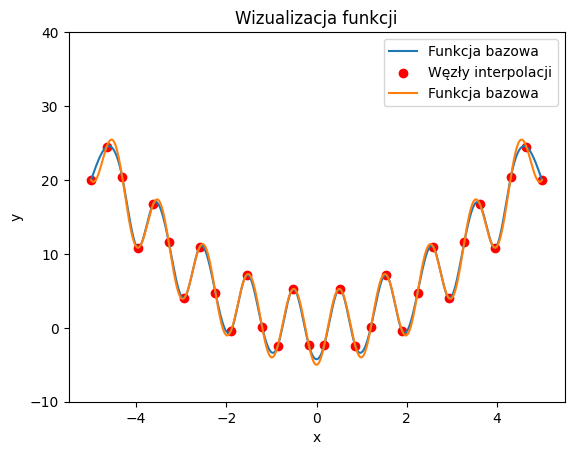

In [ ]:
N = 15
nodes = generate_nodes(func, interval[0], interval[1], N)
interpolation = get_quadratic_spline_interpolation(nodes, func_second_deriv, 'clamped')
interpolation_cubic = get_cubic_spline_interpolation(nodes)

plt.clf()
plot_function(np.linspace(interval[0],interval[1], 10000), interpolation_cubic, nodes)
plot_function(np.linspace(interval[0], interval[1], 1000), func, None, y_lim=(-10,40))
plt.show()
